# 1. Contexto
Os dados tem origem no livro "Machine Learning with R" Brett Lantz, a publicação fornece uma introdução ao aprendizado de máquina. Os dados tratam de registros sobre beneficiários de um seguro de saúde nos EUA.

## 1.1. Metas e objetivos
O objetivo desse projeto é fazer uma breve análise exploratória e construir um modelo de Machine Learning para predizer preço de seguro saúde.

## 1.2. Estrutura do dataset
|Coluna|Descrição|
|---|---|
|age|Idade|
|sex|Genêro|
|bmi|O IMC (Índice de Massa Corporal)|
|children|Número de dependentes|
|smoker|Fumante (sim ou não)|
|region|A zona residencial|
|charges|Os custos individuais do seguro|

# 2. Preparação do ambiente

## 2.1. Importação da biblitoeca e dos dados

In [278]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import OneHotEncoder

# Machine Learning
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Set2')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

In [279]:
df = pd.read_csv("../data/raw/insurance.csv")

## 2.2. Qualidade os dados

In [280]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 1338 linhas e 7 colunas.


In [281]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 3 colunas categóricas.
O dataset possui: 4 colunas numéricas.


In [282]:
# Valores únicos de cada coluna

for col in df.columns.to_list():
    print(df[col].name)
    print(df[col].unique())
    print("=" * 30)

age
[19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]
sex
['female' 'male']
bmi
[27.9   33.77  33.    22.705 28.88  25.74  33.44  27.74  29.83  25.84
 26.22  26.29  34.4   39.82  42.13  24.6   30.78  23.845 40.3   35.3
 36.005 32.4   34.1   31.92  28.025 27.72  23.085 32.775 17.385 36.3
 35.6   26.315 28.6   28.31  36.4   20.425 32.965 20.8   36.67  39.9
 26.6   36.63  21.78  30.8   37.05  37.3   38.665 34.77  24.53  35.2
 35.625 33.63  28.    34.43  28.69  36.955 31.825 31.68  22.88  37.335
 27.36  33.66  24.7   25.935 22.42  28.9   39.1   36.19  23.98  24.75
 28.5   28.1   32.01  27.4   34.01  29.59  35.53  39.805 26.885 38.285
 37.62  41.23  34.8   22.895 31.16  27.2   26.98  39.49  24.795 31.3
 38.28  19.95  19.3   31.6   25.46  30.115 29.92  27.5   28.4   30.875
 27.94  35.09  29.7   35.72  32.205 28.595 49.06  27.17  23.37  37.1
 23.75  28.975 31.35  33.915 28.785 28.3   37.4   17.765 34

In [283]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 3. Análise Exploratória de dados

## 3.1. Estatísticas descritivas

In [285]:
df.select_dtypes(include = 'number').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.21,14.05,18.00,27.00,39.00,51.00,64.00
bmi,1338.0,30.66,6.10,15.96,26.30,30.40,34.69,53.13
children,1338.0,1.09,1.21,0.00,0.00,1.00,2.00,5.00
charges,1338.0,13270.42,12110.01,1121.87,4740.29,9382.03,16639.91,63770.43


- ``age``, ``bmi`` e ``children`` aparentem distribuições próximas a normal, já que suas médias e medianas estão próximas. 
- ``charges`` tem uma assimétria positiva (a direita), pois sua média é maior que a mediana, e sua distribuição não é normal. 

In [286]:
df.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


- Maioria dos registros no dataset são de beneficiários do sexo masculino.
- Fumantes são a minoria.

## 3.2. Dados nulos 

In [287]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## 3.3. Comportamento da variável target $(y)$

In [288]:
print(f"Assimétria: {df.charges.skew()}")
print(f"Curtose: {df.charges.kurt()}")

Assimétria: 1.5158796580240388
Curtose: 1.6062986532967907


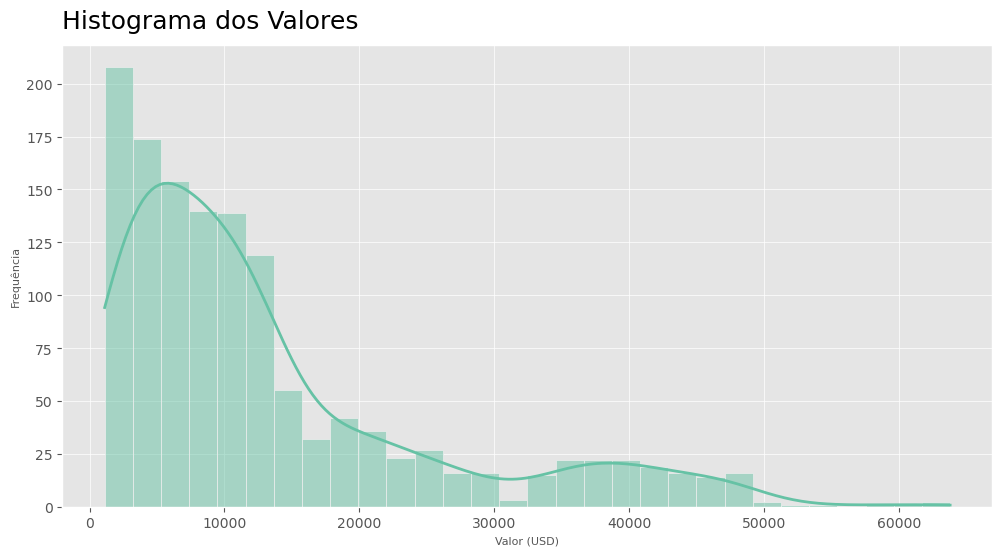

In [289]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.charges, kde = True)
ax.set_title("Histograma dos Valores", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Valor (USD)", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

### Features x target

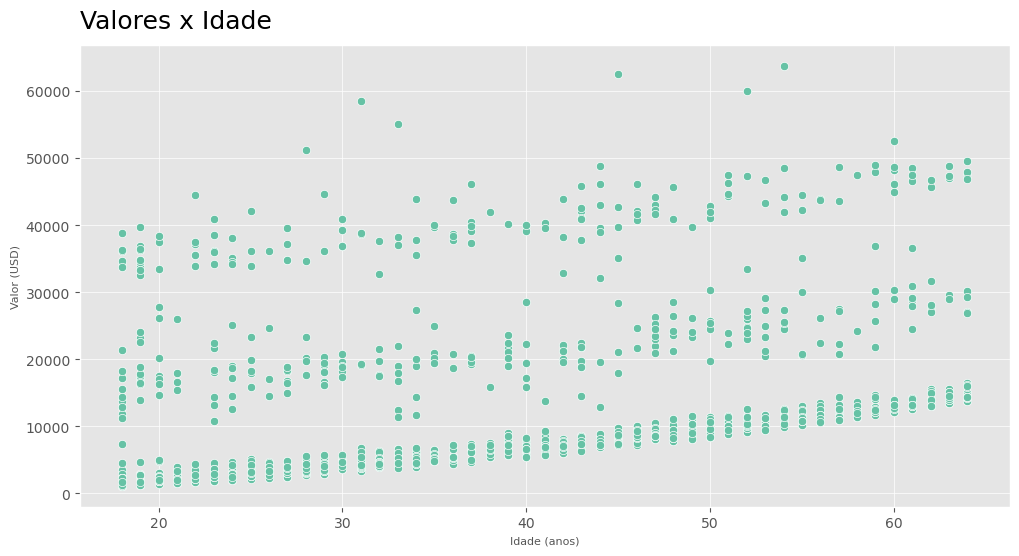

In [290]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.age, y = df.charges)
ax.set_title("Valores x Idade", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Idade (anos)", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

Existe uma correlação positiva entre a idade e os preços do seguro. O tabagismo também é um fator que pode pesar nos preços, vamos repetir o gráfico de dispersão mas agora destacando os fumantes.

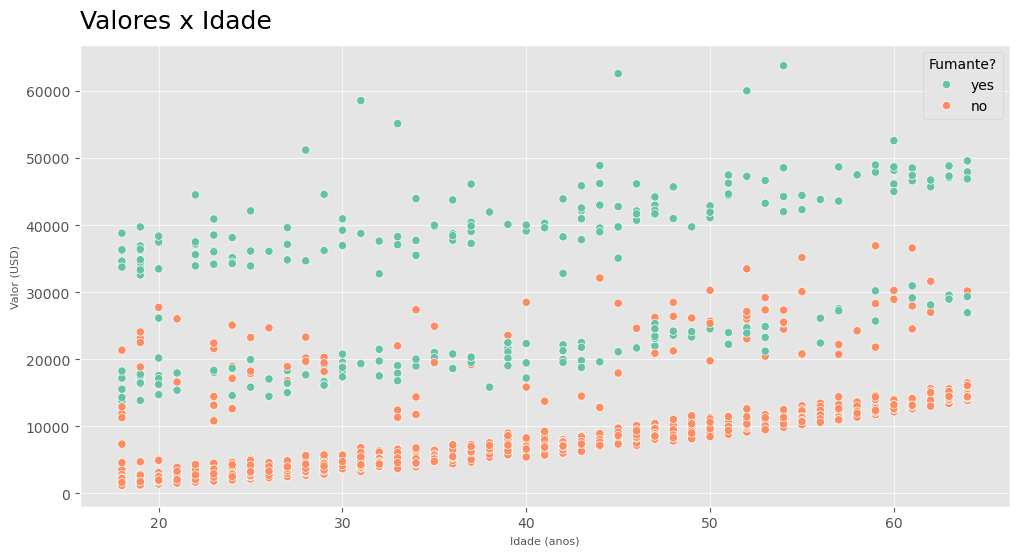

In [291]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.age, y = df.charges, hue = df.smoker)
ax.set_title("Valores x Idade", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Idade (anos)", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.legend(title = 'Fumante?')
plt.show()

Os maiores valores de seguro são pagos por fumantes.

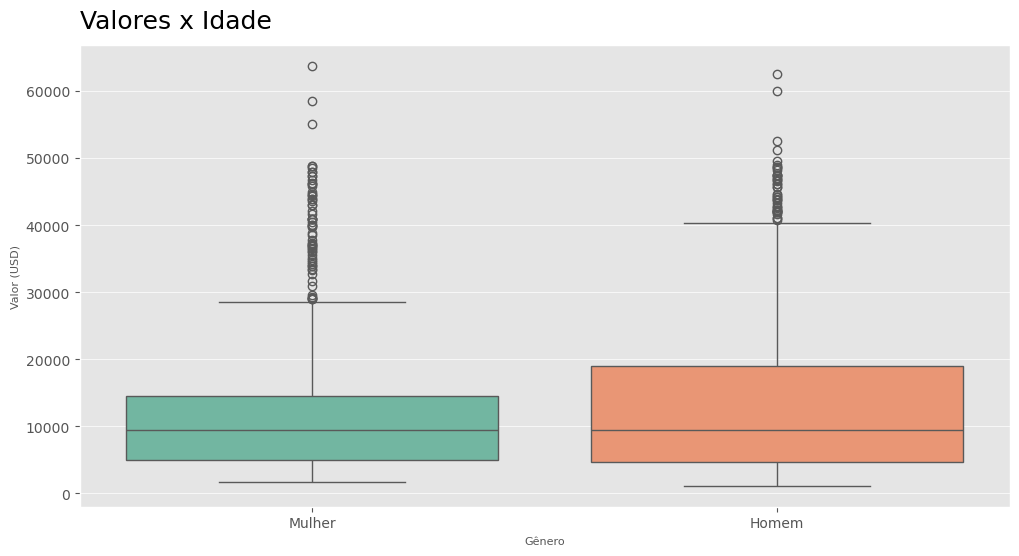

In [292]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(x = df.sex, y = df.charges, palette = 'Set2')
ax.set_title("Valores x Idade", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Gênero", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
ax.set_xticklabels({'Mulher': 'female', 'Homem': 'male'})
plt.show()

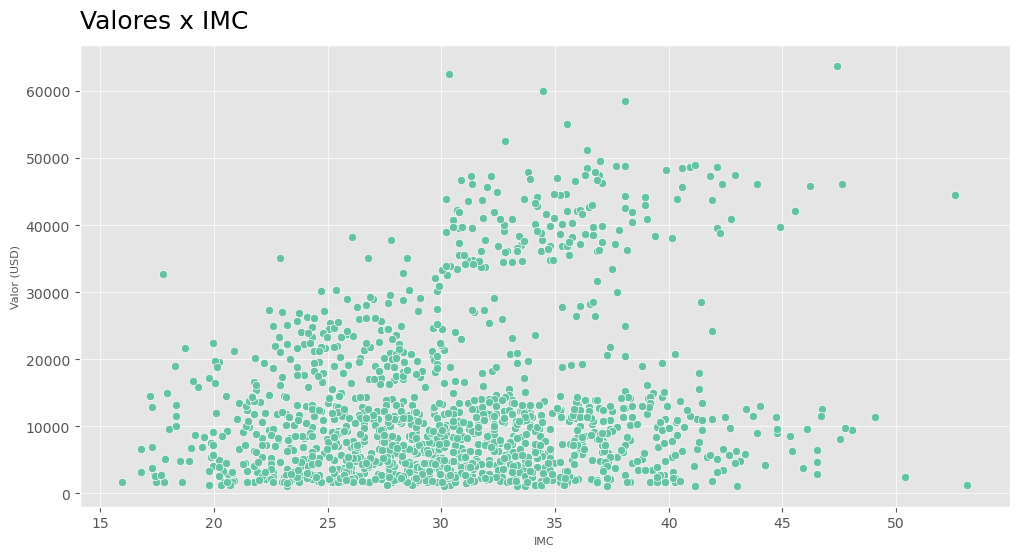

In [293]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.bmi, y = df.charges)
ax.set_title("Valores x IMC", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("IMC", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

É possível observar alguns valores extremos, vamos checar se estes são fumantes. 

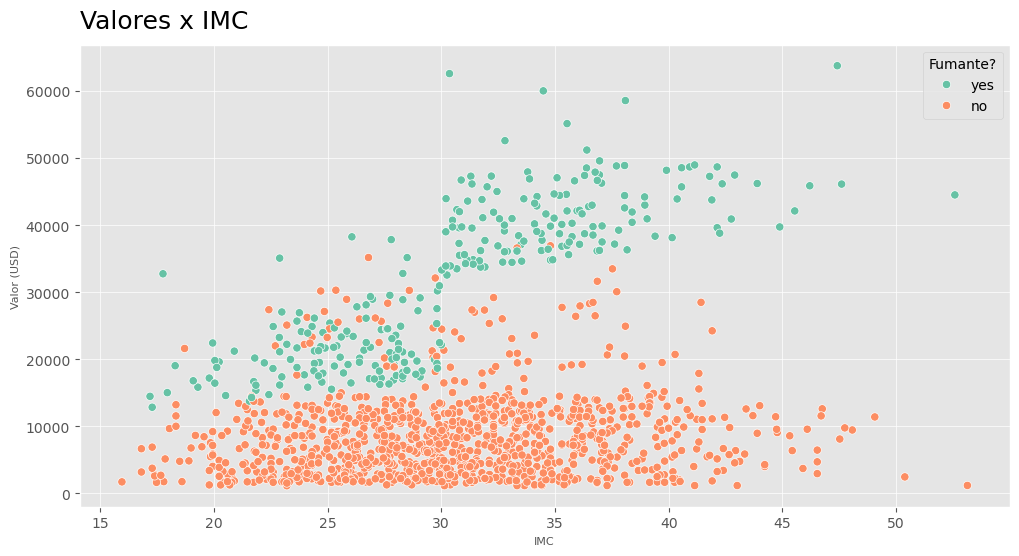

In [294]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.bmi, y = df.charges, hue = df.smoker)
ax.set_title("Valores x IMC", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("IMC", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.legend(title = 'Fumante?')
plt.show()

Novamente o tabismo se mostra um hábito que encarece o preço do seguro.

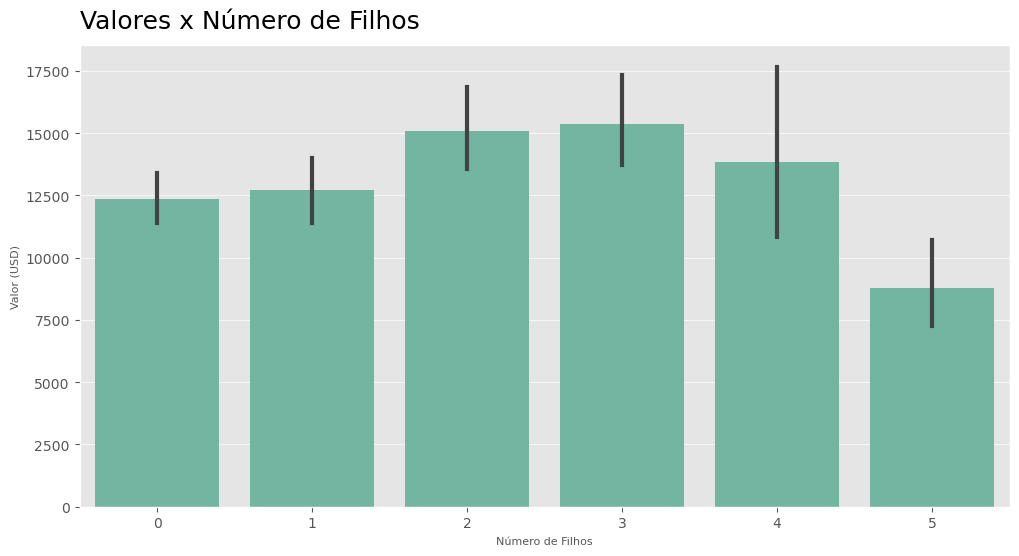

In [295]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.children, y = df.charges)
ax.set_title("Valores x Número de Filhos", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Número de Filhos", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

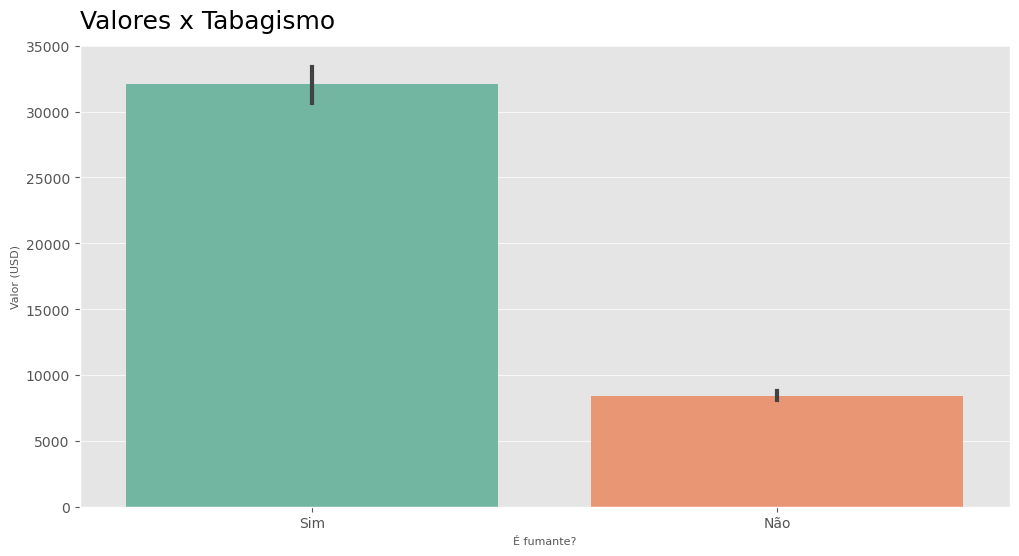

In [296]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.smoker, y = df.charges, hue = df.smoker)
ax.set_title("Valores x Tabagismo", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("É fumante?", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
ax.set_xticklabels({'Sim': 'yes', 'Não': 'no'})
plt.show()

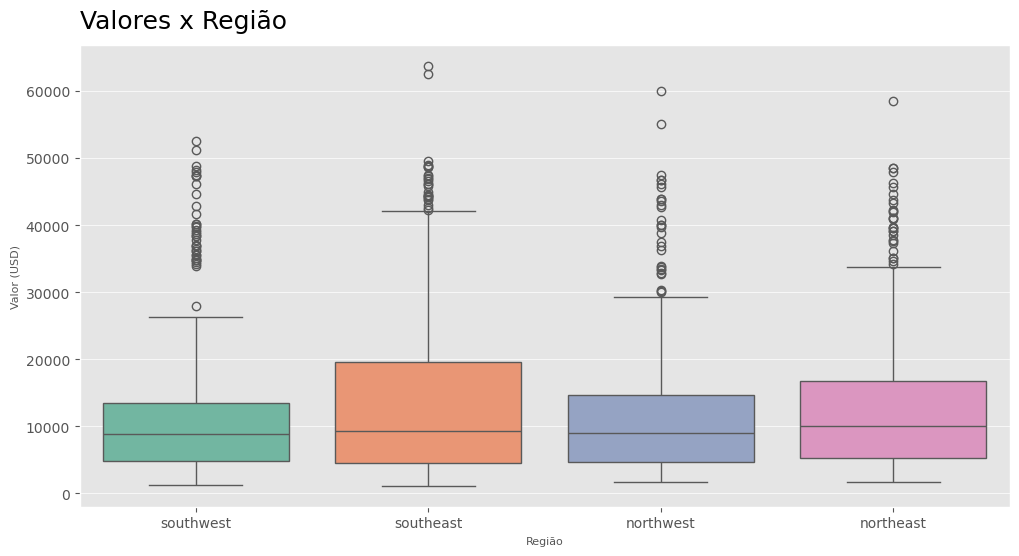

In [297]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(x = df.region, y = df.charges, hue = df.region)
ax.set_title("Valores x Região", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Região", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

## 3.4. Correlação

In [298]:
df_corr = df.copy()

In [299]:
le = LabelEncoder()
df_corr.sex = le.fit_transform(df_corr.sex)
df_corr.smoker = le.fit_transform(df_corr.smoker)
corr = df_corr.corr(numeric_only=True)

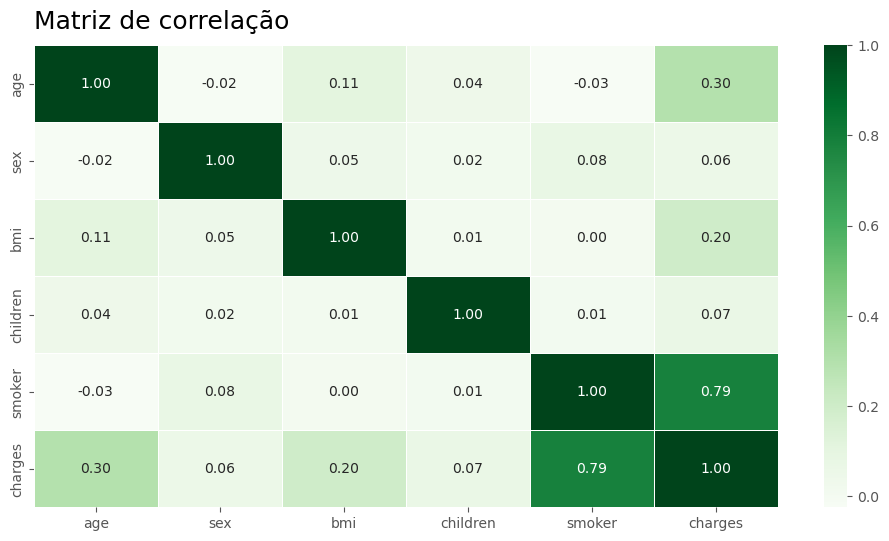

In [300]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'Greens', linecolor='white', linewidths=0.5)
ax.set_title("Matriz de correlação", loc = 'left',fontsize = 18, pad = 12)
plt.show()

Idade, IMC e o Tabagismo são as principais variáveis relacionadas ao preço do seguro. 

# 4. Preparação dos dados

## 4.1. Preparação dos dados

In [312]:
features = df.drop(columns = 'charges').columns.to_list()
target = 'charges'

cat_features = df[features].select_dtypes(include = 'object').columns.to_list()
num_features = df[features].select_dtypes(include = 'number').columns.to_list()

In [341]:
# Aplicando a transformação logarítmcia nos dados

df.charges = np.log1p(df.charges)

## 4.2. Divisão em treino e teste

In [342]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 6) (268, 6) (1070,) (268,)


## 4.3. Definindo o pré-processamento

In [344]:
cat_transformer = Pipeline([
    ('ohe', OneHotEncoder())
])

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# 5. Modelo de Regressão (XGBClassifier)

In [345]:
model = XGBRegressor()

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [346]:
y_pred = xgb.predict(X_test)
print("Métricas do Modelo")
print("=" * 20)
print(f"R2 Score: {r2_score(y_test, y_pred).round(4)}\nMSE: {mean_squared_error(y_test, y_pred).round(4)}")

Métricas do Modelo
R2 Score: 0.8095
MSE: 0.0017


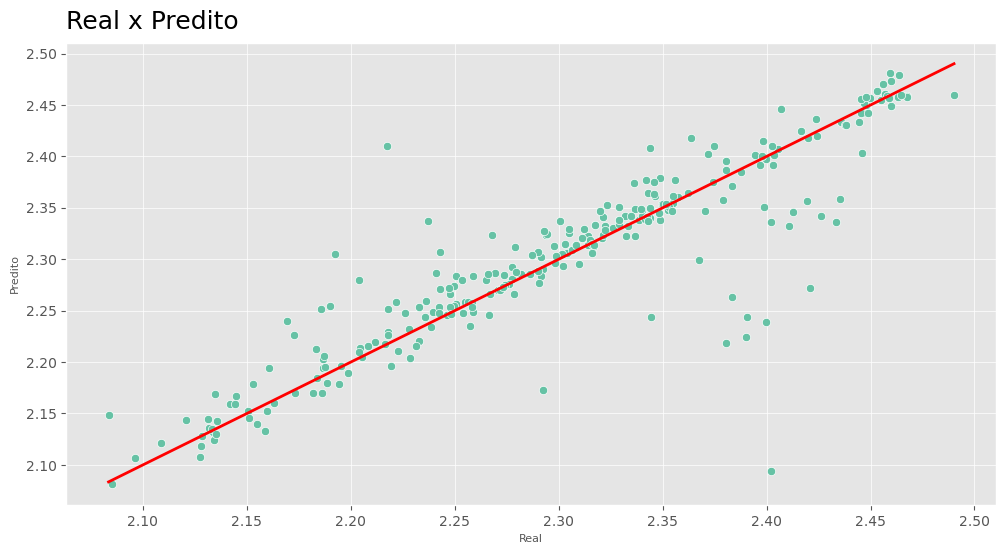

In [347]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
ax.set_title("Real x Predito", loc = 'left', fontsize = 18, pad = 10)
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("Predito", fontsize = 8)
plt.show()

<Axes: xlabel='charges', ylabel='Count'>

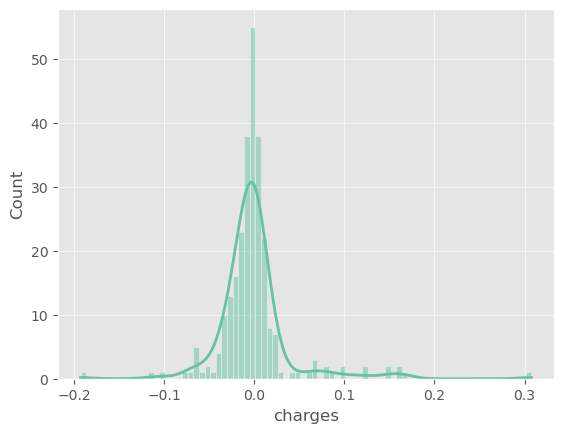

In [348]:
residuo = y_test - y_pred

sns.histplot(residuo, kde = True)